<a href="https://colab.research.google.com/github/fkvivid/DIVER/blob/main/signature_verification_pillow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing PyTorch and Pillow == 0.4

In [1]:
!pip install Pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Хэрэгтэй сангуудаа оруулна


In [2]:
%matplotlib inline
import os
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/processed_dataset'

Archive.zip  README.txt.txt			  testing
forged	     signature_verification_pillow.ipynb  training


## Туслах функцууд



In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Тохиргооны класс

In [6]:
class Config():
    training_dir = "/content/drive/My Drive/processed_dataset/training/"
    testing_dir = "/content/drive/My Drive/processed_dataset/testing/"
    train_batch_size = 64
    train_number_epochs = 500

In [7]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
  
find_classes(Config.training_dir)[1]

{'001': 0,
 '002': 1,
 '003': 2,
 '004': 3,
 '005': 4,
 '006': 5,
 '007': 6,
 '008': 7,
 '009': 8,
 '010': 9,
 '011': 10,
 '012': 11,
 '013': 12,
 '014': 13,
 '015': 14,
 '016': 15,
 '017': 16,
 '018': 17,
 '019': 18,
 '020': 19,
 '021': 20,
 '022': 21,
 '023': 22,
 '024': 23,
 '025': 24,
 '026': 25,
 '027': 26,
 '028': 27,
 '029': 28,
 '030': 29,
 'f02': 30,
 'f03': 31,
 'f04': 32,
 'f05': 33,
 'f06': 34,
 'f07': 35,
 'f08': 36,
 'f09': 37,
 'f10': 38,
 'f11': 39,
 'f12': 40,
 'f13': 41,
 'f14': 42,
 'f15': 43,
 'f16': 44,
 'f17': 45,
 'f18': 46,
 'f19': 47,
 'f20': 48,
 'f21': 49,
 'f22': 50,
 'f23': 51,
 'f24': 52,
 'f25': 53,
 'f26': 54,
 'f27': 55,
 'f28': 56,
 'f29': 57,
 'f30': 58}

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [8]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice([item for item in self.imageFolderDataset.imgs if item[1] < 29]) #Considering only genuine images for perfect pair
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
          while True:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)
            if img0_tuple[1]==img1_tuple[1]:
              break

        else:
          img1_tuple = random.choice([item for item in self.imageFolderDataset.imgs if item[1] == (img0_tuple[1] + 29)]) # Considering a pair of fake + genuine of same person's signature

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [9]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [10]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


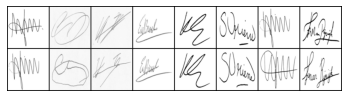

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [11]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=16,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

Its architecture might look like below,

![](https://res.mdpi.com/symmetry/symmetry-10-00385/article_deploy/html/images/symmetry-10-00385-g001.png)

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [14]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.001)

In [16]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 2.015721321105957

Epoch number 1
 Current loss 2.2386927604675293

Epoch number 2
 Current loss 5.429180145263672

Epoch number 3
 Current loss 3.1950767040252686

Epoch number 4
 Current loss 23.833274841308594

Epoch number 5
 Current loss 4.96069860458374

Epoch number 6
 Current loss 8.163864135742188

Epoch number 7
 Current loss 2.5541884899139404

Epoch number 8
 Current loss 1.722588062286377

Epoch number 9
 Current loss 2.081559181213379

Epoch number 10
 Current loss 3.9335899353027344

Epoch number 11
 Current loss 1.927654504776001

Epoch number 12
 Current loss 1.4546880722045898

Epoch number 13
 Current loss 1.4347777366638184

Epoch number 14
 Current loss 1.7882020473480225

Epoch number 15
 Current loss 1.269936442375183

Epoch number 16
 Current loss 1.432814359664917

Epoch number 17
 Current loss 1.8590272665023804

Epoch number 18
 Current loss 1.4522144794464111

Epoch number 19
 Current loss 1.5642662048339844

Epoch number 20
 Cur

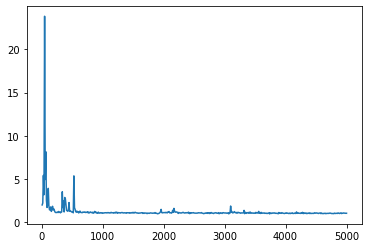

In [17]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [18]:
filepath = "/content/drive/My Drive/processed_dataset/modified_data_loader_saved_model.pt"

torch.save(net.state_dict(), filepath)

net.load_state_dict(torch.load(filepath))

<All keys matched successfully>

In [19]:
!ls '/content/drive/My Drive/processed_dataset/'

Archive.zip			     signature_verification_pillow.ipynb
forged				     testing
modified_data_loader_saved_model.pt  training
README.txt.txt


### Dataset loader class for inference

In [20]:
class InferenceSiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Some simple testing

Genuine : 6,10

Forged: 1,5,7,9

Different : 2,3,4,8

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


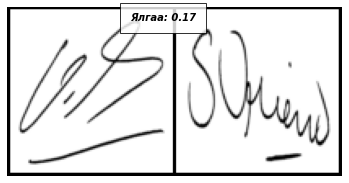

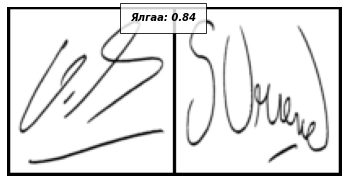

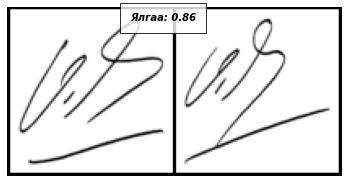

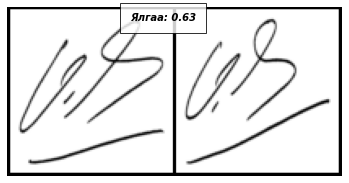

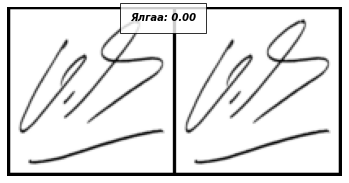

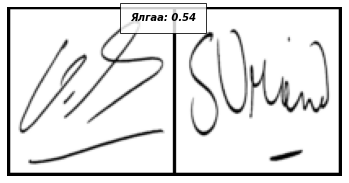

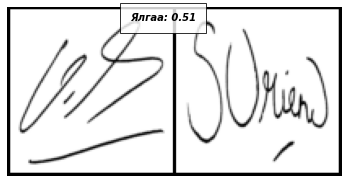

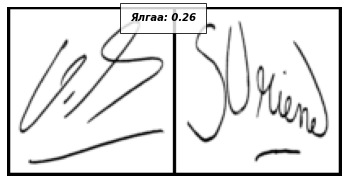

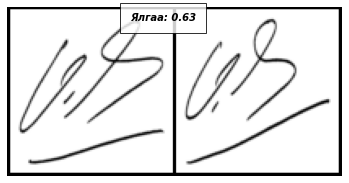

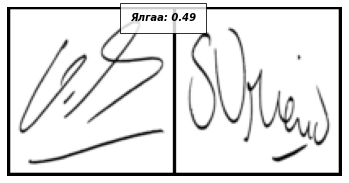

In [21]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = InferenceSiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Ялгаа: {:.2f}'.format(euclidean_distance.item()))
